# $t$ Process in Scikit Learn

This is a simple demo showcasing the integration of $t$ processes (TP)s into the scikit learn python package.
First, the existing functionality of Gaussian Processes (GP)s will be demonstrated, then the same will be done for TPs showcasing their similar interfaces and behavioural differences.

This is not meant to be a coprehensive overview of GPs and TPs, for more background information see [RW2006], [SW2014], [TW2018] and [S2024]. 

## Scikit Learn Gaussian Processes Interface
A simple example of GP regression in scikit learn is as follows:

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared
import numpy as np

X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)
X_predict = np.array([[-1.5], [-0.5], [0.5], [1.5]])

kernel = RBF(1, length_scale_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0001).fit(X_train, Y_train)
means, stds = gpr.predict(X_predict, return_std=True)

print('\nMean of predictions:')
print(means)
print('\n Standard deviation of predictions:')
print(stds)


Mean of predictions:
[-1.02199222 -0.4616725   0.4616725   1.02199222]

 Standard deviation of predictions:
[0.08621517 0.0786525  0.0786525  0.08621517]


To better visualize the predictions they can be plotted:

In [2]:
# Helper Code
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_stochastic_process(X_predict, Y_true, means, botConf, topConf, lable):
    plt.fill_between(np.reshape(X_predict, -1), botConf, topConf, color="blue", alpha=0.1)
    plt.plot(X_predict, Y_true, label="Ground Truth", color="red", linewidth=1.2)
    plt.plot(X_predict, means, label=lable, color="b", linewidth=1.2)
    plt.scatter(
        x=X_train[:, 0],
        y=Y_train,
        color="b",
        alpha=1,
        marker="x",
        s=20,
        label="Observations",
    )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.ylim(-4, 4)
    plt.show()

def norm_conf_gp(std):
    """Returns the 95% confidence interval of the normal distribution"""
    zScore = norm(0, 1).ppf(0.975)
    confidence = zScore * np.sqrt(std)
    return confidence

vec_norm_conf_gp = np.vectorize(norm_conf_gp)

np.random.RandomState(1);

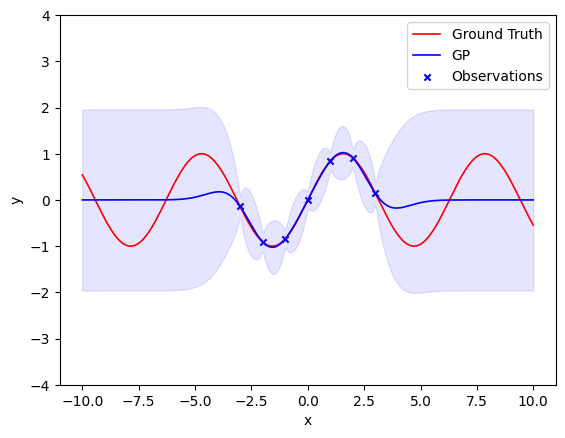

In [3]:
X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)
Y_true = np.sin(X_predict)

means, stds = gpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_gp(stds)
topConf = means + confs
botConf = means - confs

plot_stochastic_process(X_predict, Y_true, means, botConf, topConf, 'GP')


## $t$ Processes Interface

In short, TPs are generated by placing a conjugate prior over the covariance matrix of a GP then subsequently marginalizing it out. There are two primary advantages of using TPs over GPs:
1. TPs scale the covariance of the stochastic process in a Bayesian way.
2. The marginal distributions of TPs are $t$ distributions, making them *heavier tailed* and thus more robust to outliers.

Much of the literature focuses on the second property of TPs [SW2014], [TW2018] and [RW2006].

The primary disadvantage of TPs are that they cannot handle noisy observations analytically. This implementation uses the common approach of adding noise to the covariance matrix before a prior is placed over it as proposed by [SW2014]. See [S2024] for a deeper analysis of this and approximation techniques of noisy Bayesian TPs.

### $t$ Processes in Scikit Learn

This [fork](https://github.com/conradstevens/scikit-learn) of scikit learn implements TPs as a subclass of GPs giving a simple interface similar to that of GPs in scikit learn. Consider the following example:

In [4]:
from sklearn.gaussian_process import TProcessRegressor

X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)
X_predict = np.array([[-1.5], [-0.5], [0.5], [1.5]])

kernel = RBF(1, length_scale_bounds="fixed")

tpr = TProcessRegressor(kernel=kernel, alpha=0.0001, v=5).fit(X_train, Y_train)
means, stds = tpr.predict(X_predict, return_std=True)

print('\nMean of predictions:')
print(means)
print('\n Standard deviation of predictions:')
print(stds)


Mean of predictions:
[-1.02199222 -0.4616725   0.4616725   1.02199222]

 Standard deviation of predictions:
[0.06274391 0.0572401  0.0572401  0.06274391]


Remark, the mean values are the same, however the standard deviation is smaller as a result of scaling the covariance in a Bayesian way. See below the sin wave example using TPs:

In [5]:
# Helper Code
from scipy.stats import t

def norm_conf_tp(std, df):
    """Returns the 95% confidence interval of the normal distribution"""
    tShape = std ** 2 * (df - 2) / df
    tDist = t(df=df, loc=0, scale=tShape**0.5)
    confidence = tDist.ppf(0.975)
    return confidence

vec_norm_conf_tp = np.vectorize(norm_conf_tp)

np.random.RandomState(2024);

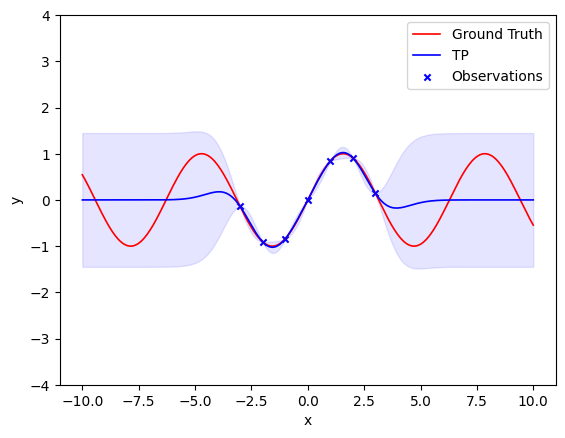

In [6]:
X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)

means, stds = tpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_tp(stds, tpr.v)
topConf = means + confs
botConf = means - confs

plot_stochastic_process(X_predict, Y_true, means, botConf, topConf, 'TP')

It can be seen the covariance of the distribution is scaled down following the observations. Also note the marginal distributions at each $x$ index are $t$ distributions.

## GP and TP Sampled Regressions
To demonstrate the *heavier tailed* properties of TPs versus GPs a series of regression can be sampled from each prior and compared.

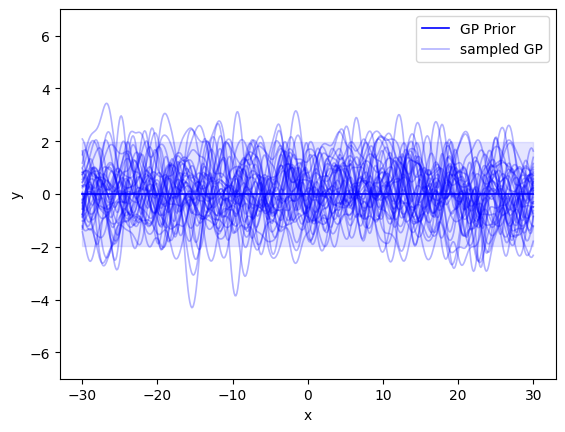

In [7]:
from scipy.interpolate import make_interp_spline

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0001)
X = np.linspace(-30, 30, 120).reshape(-1, 1)
gp_mean, gp_std = gpr.predict(X, return_std=True)
confs = vec_norm_conf_gp(gp_std)
gp_topConf = gp_mean + confs
gp_botConf = gp_mean - confs

plt.plot(X, gp_mean, label="GP Prior", color="b", linewidth=1.2, alpha=1)
plt.fill_between(X.flatten(), gp_botConf, gp_topConf, color="blue", alpha=0.1)

for i in range(1, 40):
    y_samp = gpr.sample_y(X, random_state=i)

    # Apply cubic smoothener
    spl = make_interp_spline(X.flatten(), y_samp.flatten(), k=3)
    x_smooth = np.linspace(-30, 30, 500)
    y_smooth = spl(np.linspace(-30, 30, 500))
    if i == 1:
        plt.plot(
            x_smooth,
            y_smooth,
            label="sampled GP",
            color="b",
            linewidth=1.2,
            alpha=0.3,
        )
    else:
        plt.plot(x_smooth, y_smooth, color="b", linewidth=1.2, alpha=0.3)

plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-7, 7)
plt.legend()
plt.show()

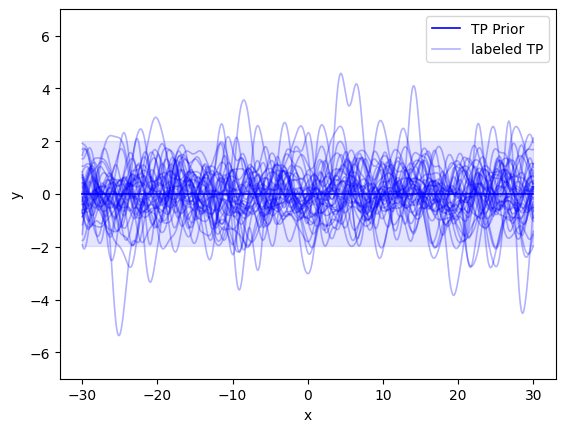

In [8]:
tpr = TProcessRegressor(kernel=kernel, alpha=0.0001, v=5)

tp_mean, tp_std = gpr.predict(X, return_std=True)
confs = vec_norm_conf_tp(tp_std, tpr.v)
tp_topConf = tp_mean + confs
tp_botConf = tp_mean - confs

plt.plot(X, tp_mean, label="TP Prior", color="b", linewidth=1.2, alpha=1)
plt.fill_between(X.flatten(), tp_botConf, tp_topConf, color="blue", alpha=0.1)

for i in range(1, 40):
    y_samp = tpr.sample_y(X, random_state=i)

    # Apply cubic smoothener
    spl = make_interp_spline(X.flatten(), y_samp.flatten(), k=3)
    x_smooth = np.linspace(-30, 30, 500)
    y_smooth = spl(np.linspace(-30, 30, 500))
    if i == 1:
        plt.plot(
            x_smooth,
            y_smooth,
            label="labeled TP",
            color="b",
            linewidth=1.2,
            alpha=0.3,
        )
    else:
        plt.plot(x_smooth, y_smooth, color="b", linewidth=1.2, alpha=0.3)

plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-7, 7)
plt.legend()
plt.show()

It can be seen that as a consequence of the $t$ distribution shape, sampled regressions from the TP prior are more volatile and extend outside the bounds more often.

## Kernel Parameter Training

In the previous examples, kernel parameters were fixed to best show the scaling properties of TPs. This section will show the implementation of kernel parameter training used to maximize the log-likelihood of the observed data, theoretically giving kernel of best fit: 

<p style="text-align: center;"> $\max_{\theta} \; \ln\bigl(p(Z_n)\bigl)$ </p>

Where $\theta$ are the kernel parameters and $Z_n$ are the observed data points.

### Gaussian Process Kernel Parameter Training
The kernel parameter training technique implemented in scikit learn is based of [RW2006] Algorithm 2.1 and scipy's *fmin_l_bfgs_b* optimizer. To compute the log-likelihood and its derivative, first consider:
$$
\begin{align}
&\text{Let } K:= K_{nn} + \Sigma_z \\
&\text{Let } Y:= Z_n - \phi(T_n) \\
&\text{Let } L := \text{Cholesky}(K) \\
&\text{Let } l_{ii} := \text{the }i^{th} \text{ diagonal of $L$} \\
&\text{Let } \alpha := L^T\backslash(L\backslash Y) \\
		&\;\;\;\;\;\;\;\;\;\;= K^{-1}Y
\end{align}
$$

Where $Z_n$ are the observed points. Then:

$$
	\begin{align}
		\ln(p(Z_n)) &= -\frac{1}{2} Y^TK^{-1}Y - \frac{1}{2}\ln(|K|) - \frac{n}{2}\ln(2\pi)  \\ 
		&= -\frac{1}{2}Y^T \alpha - \frac{1}{2}\ln(|LL^T|) - \frac{n}{2}\ln(2\pi) \\
		&= \frac{1}{2}Y\alpha - \sum_{i=1}^n \bigl( \ln(l_{ii}) \bigr) - \frac{n}{2}\ln(2\pi)
	\end{align}
$$
and
$$
\begin{align}
		\frac{\partial}{\partial \theta_1}\ln(p(Z_n)) &= \frac{1}{2}Y^TK^{-1} \frac{\partial K}{\partial \theta_1} K^{-1} Y - \frac{1}{2}\text{tr}(K^{-1} \frac{\partial K}{\partial \theta_1})\\
		&= \frac{1}{2} \alpha^T \frac{\partial K}{\partial \theta_1} \alpha - \frac{1}{2}\text{tr}(K^{-1} \frac{\partial K}{\partial \theta_1}) \\
		&= \frac{1}{2}(\text{tr}\Bigl(\alpha\alpha^T\frac{\partial K}{\partial \theta_1} \Bigl) - \text{tr}\Bigl(K^{-1} \frac{\partial K}{\partial \theta_1}\Bigl))\\
		&= \frac{1}{2}\text{tr}\Bigl(\alpha\alpha^T\frac{\partial K}{\partial \theta_1} - K^{-1} \frac{\partial K}{\partial \theta_1}\Bigl) \\
		&= \frac{1}{2} \text{tr} \Bigl( (\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial \theta_1} \Bigl) \\
	\end{align}
$$

These are implemented in the GaussianProcessRegressor class as:

In [9]:
def _log_likelihood_calc(slef, y_train, alpha, L, K):
    """Returns the log-likelihood of the multivariate Gaussian distribution.

    Parameters
    ----------
    y_train : array-like of shape (n_samples,) or (n_samples, n_targets)
              Target values.

    alpha : K^(-1) * y_train

    L : Lower cholesky decomposition of the kernel matrix K.

    K : Kernel matrix used.

    Returns
    -------
    log_likelihood : float
        Log-marginal likelihood of multivariate Gaussian distribution using
        covariance K and training data
    """
    log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
    log_likelihood_dims -= np.log(np.diag(L)).sum()
    log_likelihood_dims -= K.shape[0] / 2 * np.log(2 * np.pi)
    # the log likehood is sum-up across the outputs
    log_likelihood = log_likelihood_dims.sum(axis=-1)
    return log_likelihood

def _log_likelihood_gradient_calc(self, alpha, L, K, K_gradient):
    """Returns the log-likelihood gradient given the required algebraic terms.

    Returns
    -------
    log_likelihood_gradient : np.array
        Log-marginal likelihood gradient with respect to theta
    """
    inner_term = np.einsum("ik,jk->ijk", alpha, alpha)
    K_inv = cho_solve(
        (L, GPR_CHOLESKY_LOWER), np.eye(K.shape[0]), check_finite=False
    )
    log_likelihood_gradient_dims = 0.5 * np.einsum(
        "ijl,jik->kl", inner_term, K_gradient
    )
    log_likelihood_gradient = log_likelihood_gradient_dims.sum(axis=-1)
    return log_likelihood_gradient

Kernel parameter training can easily be used by :

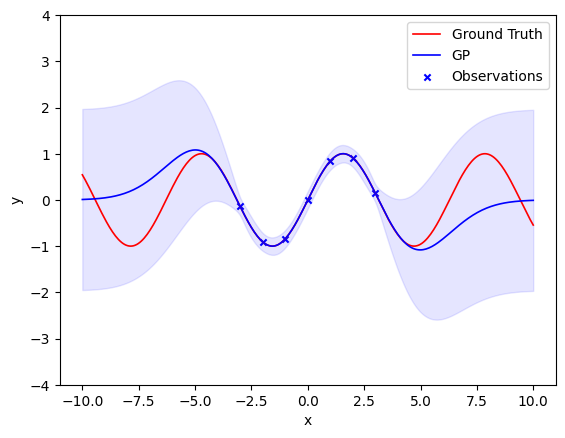

In [10]:
X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)

kernel = RBF(1, length_scale_bounds=[0.01, 10])
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0001, n_restarts_optimizer=100).fit(X_train, Y_train)

X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)
Y_true = np.sin(X_predict)

means, stds = gpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_gp(stds)
topConf = means + confs
botConf = means - confs

plot_stochastic_process(X_predict, Y_true, means, botConf, topConf, 'GP')

## $t$ Process Kernel Parameter Training

At a high level, the kernel parameter training algorithm used to train TPs is the same as what is used to train GPs. However, the equations for log-likelihood and its derivative are different. This training algorithm has been proposed by [SW2014] and [TW2018], however, never optimized and implemented untill [S2024]. To compute the log-likelihood and its derivative, first consider:

$$
\begin{align}
&\text{Let } \Psi_{nn} := \frac{v_0-2}{v_0}(K_{nn} + \Sigma_z) \\
&\text{Let } Y:= Z_n - \phi(T_n) \\
&\text{Let } L := \text{Cholesky}(\Psi_{nn}) \\
&\text{Let } l_{ii} := \text{the }i^{th} \text{ diagonal of $L$} \\
&\text{Let } \alpha := \Psi_{nn}^T\backslash(\Psi_{nn}\backslash Y) \\
		&\;\;\;\;\;\;\;\;\;\;= \Psi_{nn}^{-1}Y
\end{align}
$$

Then:

$$
\begin{align} 
\ln(p(Z_n)) &= \Gamma(\frac{v_0 + n}{2}) - \Gamma(\frac{v_0}{2}) - \frac{n}{2}\ln(v_0\pi) - \frac{1}{2} \ln(|\Psi_{nn}|) - \frac{v_0 + n}{2} \ln(1 + \frac{(\phi(T_n) - \check{Z}_n)^T \Psi_{nn}^{-1} (\phi(T_n) - \check{Z}_n)}{v_0}) \\ 
&= \Gamma(\frac{v_0 + n}{2}) - \Gamma(\frac{v_0}{2}) - \frac{n}{2}\ln(v_0\pi) - \frac{1}{2} \ln(|K|) - \frac{v_0 + n}{2} \ln(1 + \frac{Y^T K^{-1} Y}{v_0}) \\ 
&= \Gamma(\frac{v_0 + n}{2}) - \Gamma(\frac{v_0}{2}) - \frac{n}{2}\ln(v_0\pi) - \frac{1}{2} \ln(|LL^T|) - \frac{v_0 + n}{2} \ln(1 + \frac{Y^T \alpha}{v_0}) \\ 
&= \Gamma(\frac{v_0 + n}{2}) - \Gamma(\frac{v_0}{2}) - \frac{n}{2}\ln(v_0\pi) - \sum_{i=1}^n\bigl( \ln(l_{ii}) \bigr) - \frac{v_0 + n}{2} \ln(1 + \frac{Y^T \alpha}{v_0}) \\
&= \Gamma(\frac{v_0 + n}{2}) - \Gamma(\frac{v_0}{2}) - \frac{n}{2}\ln(v_0\pi) - \sum_{i=1}^n\bigl( \ln(l_{ii}) \bigr) - \frac{v_0 + n}{2} \ln(1 + \frac{(\phi(T_n) - \check{Z}_n)^T \alpha}{v_0})
\end{align}
$$

and

$$
\begin{align} 
\frac{\partial}{\partial \theta_1}\ln\bigl(p(Z)\bigl) &= \frac{\partial}{\partial \theta_1} \Bigl((-\frac{1}{2}\ln(|\Psi_{nn}|)\Bigl) + \frac{\partial}{\partial \theta_1} \Bigl( - \frac{v_0 + n}{2}\ln \bigl( 1+\frac{(\phi(T_n) - \check{Z}_n)^T \Psi_{nn}^{-1} (\phi(T_n) - \check{Z}_n)}{v_0}\bigl) \Bigl) \\
&= \frac{\partial}{\partial \theta_1} \Bigl((-\frac{1}{2}\ln(|\psi_{nn}|)\Bigl) + \frac{\partial}{\partial \theta_1} \Bigl( - \frac{v_0 + n}{2}\ln \bigl( 1+\frac{Y^T \psi_{nn}^{-1}Y}{v_0}\bigl) \Bigl) \\
&= \frac{v_0 + n}{v_0+Y^T \psi_{nn}^{-1} Y} \times \frac{1}{2} Y^T\psi_{nn}^{-1} \frac{\partial \psi_{nn}}{\partial \theta_1} \psi_{nn}^{-1} Y - \frac{1}{2}\text{tr}(\psi_{nn}^{-1} \frac{\partial \psi_{nn}}{\partial \theta_1})\\
&= \frac{v_0 + n}{v_0 + Y^T\alpha}\times\frac{1}{2} \text{tr}(\alpha\alpha^T \frac{\partial \psi_{nn}}{\partial \theta_1}) - \frac{1}{2}\text{tr}(\psi_{nn}^{-1} \frac{\partial \psi_{nn}}{\partial \theta_1})\\
&= \frac{1}{2}\text{tr}\Bigl(\frac{v_0  + n}{v_0 + Y^T\alpha} \times \alpha\alpha^T \frac{\partial \psi_{nn}}{\partial \theta_1} -  \psi_{nn}^{-1} \frac{\partial \psi_{nn}}{\partial \theta_1}\Bigl)\\
&= \frac{1}{2}\text{tr}\Bigl(\Bigl(\frac{v_0 + n}{v_0 + Y^T\alpha} \times \alpha\alpha^T - (LL^T)^{-1} \Bigl) \frac{\partial \psi_{nn}}{\partial \theta_1} \Bigl) \\
&= \frac{1}{2}\text{tr}\Bigl(\Bigl(\frac{v_0 + n}{v_0 + (\check{Z}_n - \phi(T_n)^T)\alpha} \times \alpha\alpha^T - (LL^T)^{-1} \Bigl) \frac{\partial \psi_{nn}}{\partial \theta_1} \Bigl)
	\end{align}
$$


These are implemented in the TProcessRegressor class as:

In [11]:
# Template code to not get errors when deffining the likelihood functions.
from scipy.special import gamma as gam
class TProcessRegressor_Demo():
    def fit():
        self.c1 = gam(self.v0 / 2)
        self.c2 = np.log(self.v0 * np.pi)
        self.c_fit1 = self.v / 2
        self.log_likelihood_dims_const = (gam(self.c_fit1) - self.c1 - self.n / 2 * self.c2)

In [12]:
class TProcessRegressor_Demo():
    def _log_likelihood_calc(self, y_train, alpha, L, K):
        """Returns the log-likelihood given L and the training points.

        Parameters
        ----------
        y_train : array-like of shape (n_samples,) or (n_samples, n_targets)
                  Target values.

        alpha : K^(-1) * y_train

        L : Lower cholesky decomposition of the kernel matrix K.

        K : Kernel matrix used.

        Returns
        -------
        log_likelihood : float
            Log-marginal likelihood of multivariate T distribution
            using covariance K and training data
        """
        # Log-likelihood function can be found in [TW2018]
        ### Change to shape of kernel Parameter ###
        L = L * ((self.v0 - 2) / self.v0) ** 0.5

        self.m_dis = np.einsum("ik,ik->k", y_train, alpha)
        self.shape_m_dism_dis = self.m_dis * self.v0 / (self.v0 - 2)
        log_likelihood_dims = self.log_likelihood_dims_const
        log_likelihood_dims -= self.c_fit1 * np.log(1 + self.shape_m_dism_dis / self.v0)
        log_likelihood_dims -= np.log(np.diag(L)).sum()
        log_likelihood = log_likelihood_dims.sum(axis=-1)
        return log_likelihood

        def _log_likelihood_gradient_calc(self, alpha, L, K, K_gradient):
            """Returns the log-likelihood gradient given the required algebraic terms.
    
            Parameters
            ----------
            y_train : array-like of shape (n_samples,) or (n_samples, n_targets)
                      Target values.
    
            alpha : K^(-1) * y_train
    
            L : Lower cholesky decomposition of the kernel matrix K.
    
            K : Kernel matrix used.
    
            Returns
            -------
            log_likelihood_gradient : np.array
                Log-marginal likelihood gradient with respect to theta
            """
            L = L * ((self.v0 - 2) / self.v0) ** 0.5
            alpha = alpha * self.v0 / (self.v0 - 2)
            K_gradient = K_gradient * (self.v0 - 2) / self.v0
    
            inner_term = np.einsum("ik,jk->ijk", alpha, alpha)
            inner_term = self.v / (self.v0 + self.shape_m_dism_dis) * inner_term
            K_inv = cho_solve(
                (L, GPR_CHOLESKY_LOWER), np.eye(K.shape[0]), check_finite=False
            )
            inner_term -= K_inv[..., np.newaxis]
            log_likelihood_gradient_dims = 0.5 * np.einsum(
                "ijl,jik->kl", inner_term, K_gradient
            )
            # the log likehood gradient is the sum-up across the outputs
            log_likelihood_gradient = log_likelihood_gradient_dims.sum(axis=-1)
            return log_likelihood_gradient

Just as in the GP case, kernel parameter tuning can easily be used:

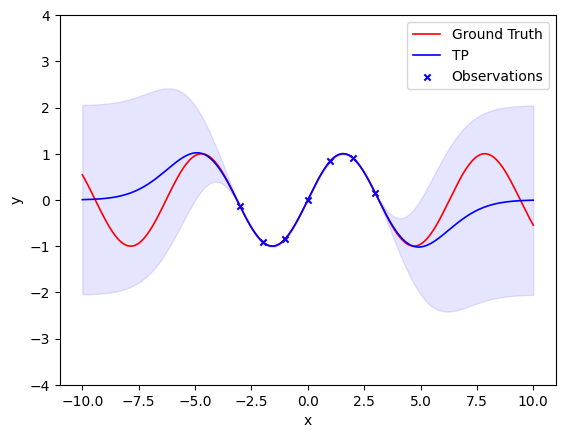

In [13]:
X_train = np.array([[-3], [-2], [-1], [0], [1], [2], [3]])
Y_train = np.sin(X_train)

kernel = RBF(1, length_scale_bounds=[0.01, 10])
tpr = TProcessRegressor(kernel=kernel, v=5, alpha=0.0001, n_restarts_optimizer=100).fit(X_train, Y_train)

X_predict = np.linspace(-10, 10, num=300).reshape(-1, 1)
Y_true = np.sin(X_predict)

means, stds = tpr.predict(X_predict, return_std=True)
confs = vec_norm_conf_tp(stds, tpr.v)
topConf = means + confs
botConf = means - confs

plot_stochastic_process(X_predict, Y_true, means, botConf, topConf, 'TP')

When training the kernel parameters, the predicted values of TPs and GPs are typically more similar. However, in this case it can be seen there is slightly more confidence near the observed parts of the curve.

## References

[RW2006] `Carl E. Rasmussen and Christopher K.I. Williams,
"Gaussian Processes for Machine Learning",
MIT Press 2006 <https://www.gaussianprocess.org/gpml/chapters/RW.pdf>`

[SW2014] `Amar Shah, Andrew Gordon Wilson, Zoubin Ghahramani,
"Student-t Processes as Alternatives to Gaussian Processes",
arxiv > stat > arXiv:1402.4306 <https://arxiv.org/abs/1402.4306>`

[TW2018] `Brendan D. Tracey, David H. Wolpert,
"Upgrading from Gaussian Processes to Student's-T Processes"
arxiv > stat > arXiv:1801.06147 <https://arxiv.org/abs/1801.06147>`

[S2024] `Stevens Conrad
"Towards Analytic Informative Path Planning",
The University of Sydney Library <https://hdl.handle.net/2123/33299>`